# Tutorial on MDN

From https://mikedusenberry.com/mixture-density-networks.

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams['figure.figsize'] = [8, 8]
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(0)


In [3]:
# generate the data
n = 2500
d, t = 1, 1
x_train = np.random.uniform(0, 1, (n, d)).astype(np.float32)
noise = np.random.normal(-0.1, 0.1, (n, t)).astype(np.float32)
y_train = x_train + 0.3*np.sin(2*np.pi*x_train) + noise
x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)


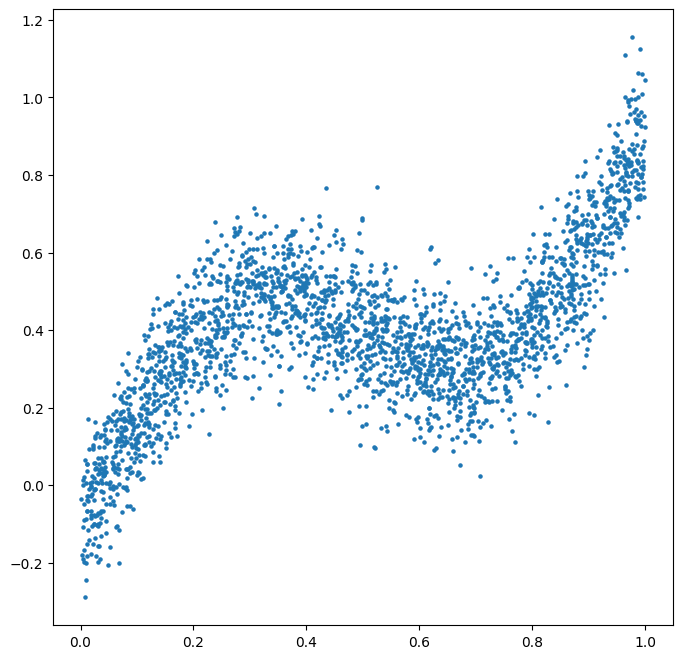

In [4]:
# plot
fig = plt.figure()
plt.scatter(x_train, y_train, s=5)
plt.show()

In [5]:
# define a simple neural network
h = 15
w1 = Variable(torch.randn(d, h)*np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t)*np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
    out = torch.tanh(x.mm(w1) + b1)
    out = out.mm(w2) + b2
    return out

x = Variable(torch.from_numpy(x_train))
y = Variable(torch.from_numpy(y_train))

opt = optim.Adam([w1, b1, w2, b2], lr=0.01)

for e in range(2000):
    opt.zero_grad()
    out = forward(x)
    loss = F.mse_loss(out, y)
    if e%100 == 0:
        print(e, loss.item())
    loss.backward()
    opt.step()

0 0.03635986149311066
100 0.025957399979233742
200 0.022085247561335564
300 0.010858832858502865
400 0.010123916901648045
500 0.0100835170596838
600 0.010059545747935772
700 0.010056095197796822
800 0.010052504017949104
900 0.010049480013549328
1000 0.01029004156589508
1100 0.010043884627521038
1200 0.01004467811435461
1300 0.01003915537148714
1400 0.010037001222372055
1500 0.010035485029220581
1600 0.010033704340457916
1700 0.010180382058024406
1800 0.010031245648860931
1900 0.01003009732812643


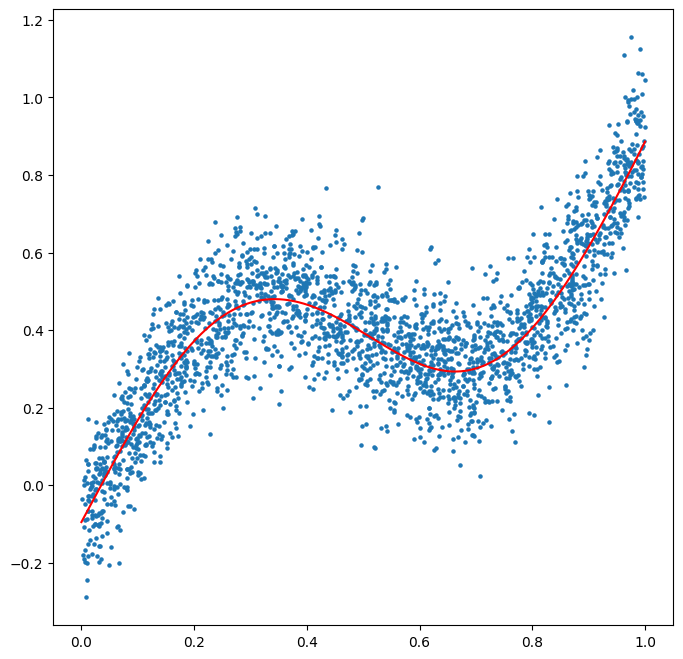

In [6]:
fig = plt.figure()
plt.scatter(x_train, y_train, s=5)
out = forward(Variable(torch.from_numpy(x_test)))
plt.plot(x_test, out.data.numpy(), color='r')
plt.show()

## Invert the problem

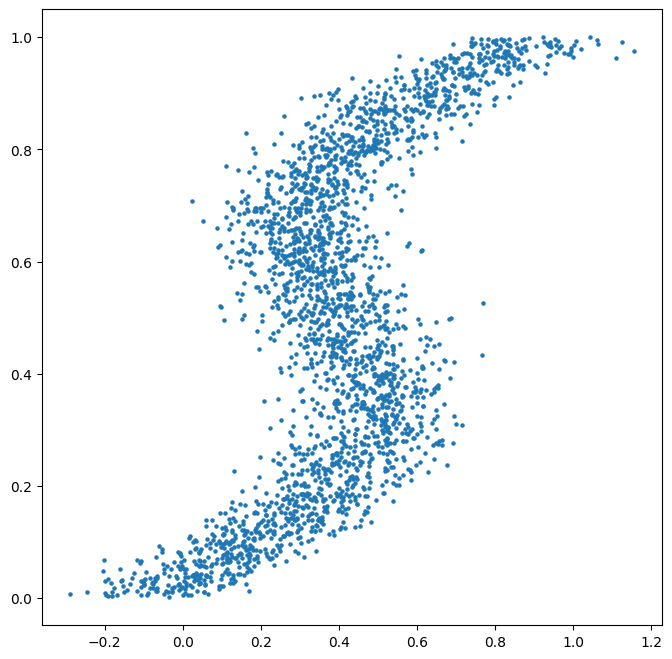

In [7]:
x_train_inv = y_train
y_train_inv = x_train
x_test = np.linspace(-0.1, 1.1, n).reshape(-1, 1).astype(np.float32)

fig = plt.figure()
plt.scatter(x_train_inv, y_train_inv, s=5)
plt.show()

In [8]:
# define a simple neural network
h = 15
w1 = Variable(torch.randn(d, h)*np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t)*np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
    out = torch.tanh(x.mm(w1) + b1)
    out = out.mm(w2) + b2
    return out

x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

opt = optim.Adam([w1, b1, w2, b2], lr=0.01)

for e in range(2000):
    opt.zero_grad()
    out = forward(x)
    loss = F.mse_loss(out, y)
    if e%100 == 0:
        print(e, loss.item())
    loss.backward()
    opt.step()

0 1.290662169456482
100 0.05331956222653389
200 0.053119104355573654
300 0.05304460600018501
400 0.052973005920648575
500 0.052908509969711304
600 0.052852582186460495
700 0.052805133163928986
800 0.0527653694152832
900 0.05273229256272316
1000 0.0527048297226429
1100 0.052681952714920044
1200 0.05266272649168968
1300 0.05264624208211899
1400 0.052631646394729614
1500 0.052618127316236496
1600 0.052604883909225464
1700 0.052591077983379364
1800 0.05257578566670418
1900 0.05255787819623947


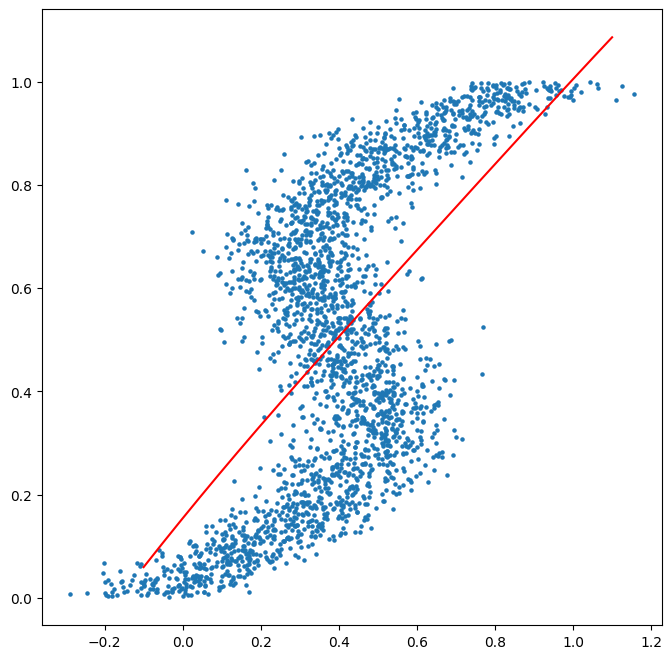

In [9]:
fig = plt.figure()
plt.scatter(x_train_inv, y_train_inv, s=5)
out = forward(Variable(torch.from_numpy(x_test)))
plt.plot(x_test, out.data.numpy(), color='r')
plt.show()

Hmm fails because P(x|y) is multimodal!
Need
## Mixture Density Networks

The basic idea is to model your distirbution a a mixture of $k$ Gaussians(other distributions are available)

$$P(y|x) = \sum_k \pi_k(x) N(y|\mu_k(x), \textbf{I}\sigma_k^2(x))$$

where the mixture weights $\pi_k$, the means $\mu_k$ and the variance $\sigma_k$ are all functions of the neural network weights.

In [16]:
h=50 # number of hidden units
k = 30 # number of mixtures to consider
d_pi = k
d_sigmasq = k # note that we are condisdering the case where we have a diagonal covariance matrix
d_mu = t*k # hmm I dont remmeber what t is

w1 = Variable(torch.randn(d, h)*np.sqrt(2/(d+h)), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w_pi = Variable(torch.randn(h, d_pi)*np.sqrt(2/(h+d)), requires_grad=True)
b_pi = Variable(torch.zeros(1, d_pi), requires_grad=True)
w_sigmasq = Variable(torch.randn(h, d_sigmasq)*np.sqrt(2/(h+d)), requires_grad=True)
b_sigmasq = Variable(torch.zeros(1, d_sigmasq), requires_grad=True)
w_mu = Variable(torch.randn(h, d_mu)*np.sqrt(2/(h+d)), requires_grad=True)
b_mu = Variable(torch.zeros(1, d_mu), requires_grad=True)

def forward(x):
    out = torch.tanh(x.mm(w1) + b1)
    pi = F.softmax(out.mm(w_pi) + b_pi, dim=1)
    sigmasq = torch.exp(out.mm(w_sigmasq) + b_sigmasq)
    mu = out.mm(w_mu) + b_mu
    return pi, sigmasq, mu

def gaussian_pdf(x, mu, sigmasq):
    return (1/torch.sqrt(2*np.pi*sigmasq)) * torch.exp((-1/(2*sigmasq)) * torch.norm((x-mu), 2, 1)**2)

def loss_fn(pi, sigmasq, mu, target):
    losses = Variable(torch.zeros(n))
    for i in range(k):
        likelihood_z_x = gaussian_pdf(target, mu[:, i*t:(i+1)*t], sigmasq[:, i])
        prior_z = pi[:, i]
        losses += prior_z*likelihood_z_x
    loss = torch.mean(-torch.log(losses))
    return loss

opt = optim.Adam([w1, b1, w_pi, b_pi, w_sigmasq, b_sigmasq, w_mu, b_mu], lr=0.008)

x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

for e in range(2000):
    opt.zero_grad()
    pi, sigmasq, mu = forward(x)
    loss = loss_fn(pi, sigmasq, mu, y)
    if e%100 == 0:
        print(e, loss.item())
    loss.backward()
    opt.step()


0 1.0800907611846924
100 -0.45441582798957825
200 -0.6141533255577087
300 -0.6396828889846802
400 -0.6677170991897583
500 -0.669487714767456
600 -0.6681727766990662
700 -0.688209593296051
800 -0.6749684810638428
900 -0.6904649138450623
1000 -0.6925017833709717
1100 -0.6747833490371704
1200 -0.6957688927650452
1300 -0.6912514567375183
1400 -0.6851772665977478
1500 -0.6995232105255127
1600 -0.7003921866416931
1700 -0.6983131766319275
1800 -0.7066382169723511
1900 -0.704910159111023


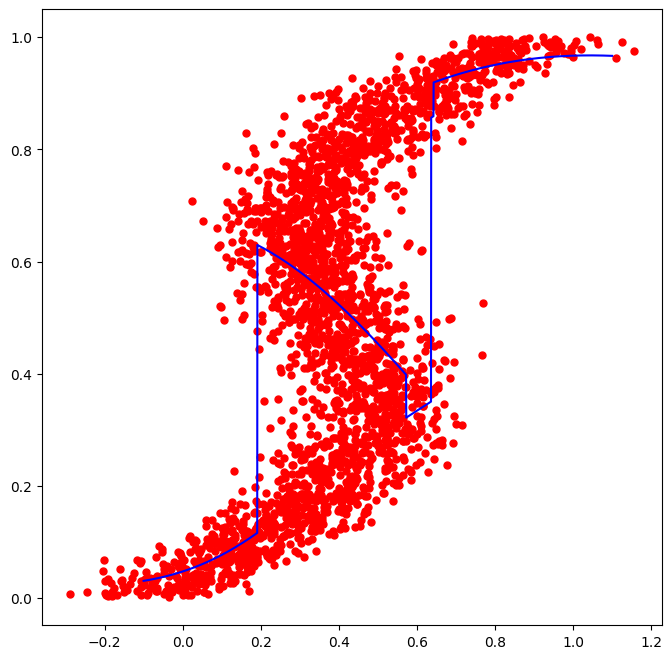

In [17]:
def sample_mode(pi, sigmasq, mu):
    # sample most probable mixture
    n, k = pi.shape
    _, kt = mu.shape
    t = int(kt/k)
    _, max_component = torch.max(pi, 1) # mixture with the largest probability
    out = Variable(torch.zeros(n, t))
    for i in range(n):
        for j in range(t):
            out[i, j] = mu[i, max_component[i]*t + j]
    return out

def sample_preds(pi, sigmasq, mu, samples=10):
    N, K = pi.shape
    _, KT = mu.shape
    T = int(KT/K)
    out = Variable(torch.zeros(N, samples, T))
    for i in range(N):
        for j in range(samples):
            u = np.random.uniform()
            prob_sum = 0
            for k in range(K):
                prob_sum += pi.data[i, k]
                if u < prob_sum:
                    for t in range(T):
                        out[i, j, t] = np.random.normal(mu.data[i, k*T + t], np.sqrt(sigmasq.data[i, k]))
                    break
    return out

# samples
pi, sigmasq, mu = forward(Variable(torch.from_numpy(x_test)))
cond_mode = sample_mode(pi, sigmasq, mu)
pred = sample_preds(pi, sigmasq, mu, samples=10)

fig = plt.figure()
plt.plot(x_train_inv, y_train_inv, 'ro', markersize=5)
plt.plot(x_test, cond_mode.data.numpy(), 'b')

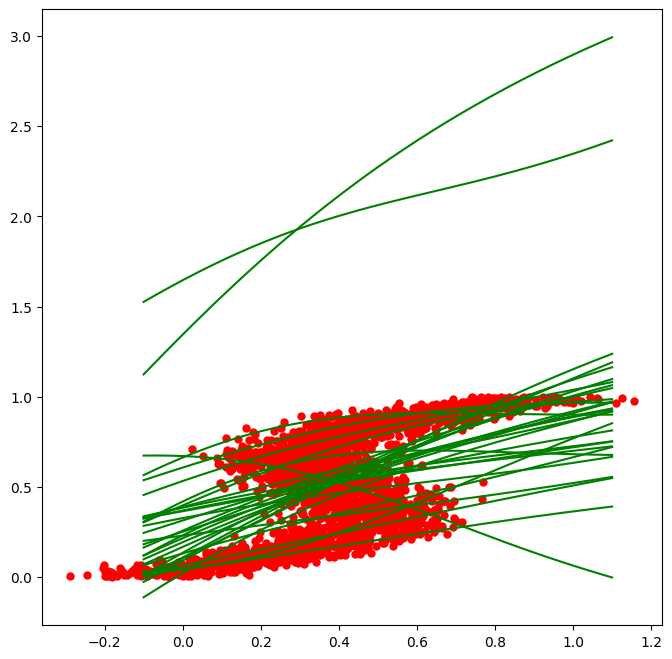

In [18]:
plt.plot(x_train_inv, y_train_inv, 'ro', markersize=5)
plt.plot(x_test, mu.data.numpy(), 'g')

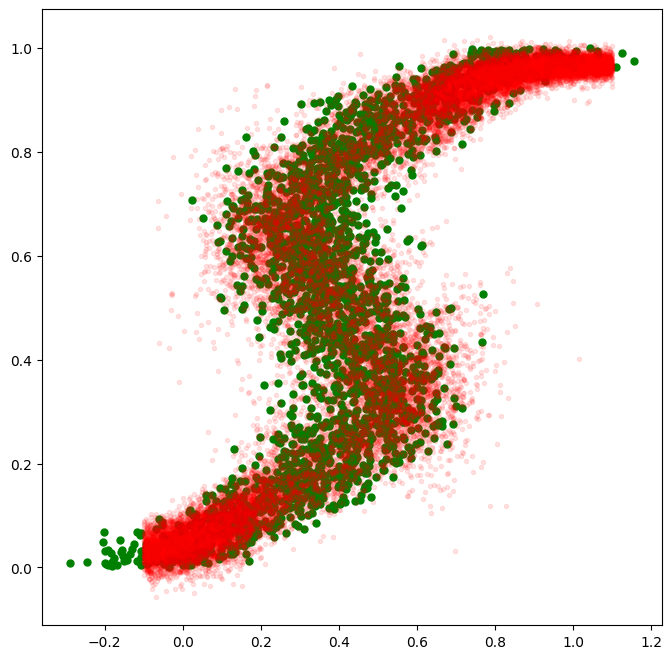

In [20]:
plt.plot(x_train_inv, y_train_inv, 'go', markersize=5)
for i in range(pred.shape[1]):
    plt.plot(x_test, pred.data.numpy()[:, i].reshape(n, 1), 'r.', alpha=0.1)
